# DIPSHIFT Fitter

In [1]:
#@title Setup fitter
import sys
if 'google.colab' in sys.modules:
    !pip install sleepy-nmr
else:
    sys.path.append('/Users/albertsmith/Documents/GitHub/')
    sys.path.append('/Users/albertsmith/Documents/GitHub.nosync/')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from copy import copy

dHC=sl.Tools.dipole_coupling(.109,'1H','13C')
tetra=np.arccos(-1/3)

class DIPSHIFT():
    def __init__(self,nH:int=1,sym:bool=True,vr:float=5000,N:int=17,dHX=dHC,LG=False,pwdavg:str='rep144',
                 n_gamma:int=256):
        self.LG=LG
        self._dHX=dHX
        self._sym=sym
        
        self._ex=[None,None,None]
        self._Azz=[None,None,None]
        self._xt=[None,None,None]
        
        self._pwdavg=pwdavg
        self.n_gamma=n_gamma
        self.exsym=None

        self.nH=nH
         
        super().__setattr__('N',N)
        super().__setattr__('vr',vr)

        
    @property
    def sym(self):
        return self._sym
    @sym.setter
    def sym(self,sym):
        self._sym=sym
        self.nH=self.nH  #This looks strange, but triggers parameter updates
        
    @property
    def nH(self):
        return self._nH
    
    @nH.setter
    def nH(self,nH):
        assert nH in [1,2,3],'nH must be 1, 2, or 3'
        
        self._nH=nH
        if self._Azz[nH-1] is not None:return
        
        if self.sym and self.exsym is None:
            self.exsym=sl.ExpSys(v0H=500,Nucs=['13C','1H'],
                            pwdavg=sl.PowderAvg('bcr50'),n_gamma=self.n_gamma)
        
            self.exsym.set_inter('dipole',i0=0,i1=1,delta=1,euler=[0,0,0])
            H=self.exsym.Hamiltonian()[0]
            self._Azzsym=np.array([Hi.rotInter.Azz[:,[0,1,3,4]]/np.sqrt(6) for Hi in H.Hinter])
        else:
            if self._ex[nH-1] is None:
                ex=sl.ExpSys(v0H=500,Nucs=['13C',*['1H']*nH],
                                      pwdavg=sl.PowderAvg(self._pwdavg),n_gamma=self.n_gamma)

                beta=0 if nH==1 else (tetra/2 if nH==2 else tetra)

                for k in range(nH):
                    ex.set_inter('dipole',i0=0,i1=k+1,delta=1,
                                      euler=[0,beta,k*2*np.pi/nH])    
                self._ex[nH-1]=ex

                H=self.ex.Hamiltonian()[0]
                self._Azz[nH-1]=np.array([Hi.rotInter.Azz[:,[0,1,3,4]]/np.sqrt(6) for Hi in H.Hinter])

    def __setattr__(self,name,value):
        if name in ['N','vr']:
            if getattr(self,name)!=value:
                self._xt=[None,None,None]
        super().__setattr__(name,value)

    @property
    def dHX(self):
        return self._dHX*(np.sqrt(1/3) if self.LG else 1)
    
    @property
    def ex(self):
        return self._ex[self.nH-1]
        
    @property
    def Azz(self):
        return np.repeat(self._Azzsym,self.nH,axis=0) if self.sym else self._Azz[nH-1]
    
    @property
    def pwdavg(self):
        return self.exsym.pwdavg if self.sym else self.ex.pwdavg
        
    @property
    def tau(self):
        return np.arange(self.N)*1/(self.vr*(self.N-1))

    @property
    def exp(self):
        return np.array([1j/(q*2*np.pi*self.vr)*(np.exp(-1j*q*self.tau*2*np.pi*self.vr)-1) for q in [-2,-1,1,2]]).T

    @property
    def xt(self):
        if self._xt[self.nH-1] is None:
            self._xt[self.nH-1]=np.array([[(Azz0*exp0).sum(-1).real for Azz0 in self.Azz] for exp0 in self.exp],dtype=float)
        return self._xt[self.nH-1]

    def I(self,S):
        omegat=np.cos(2*np.pi*self.dHX*S*self.xt)
        I=(omegat.prod(1)*self.pwdavg.weight).sum(-1)
        return I

    def plot(self,S=None,A=None,ax=None,I=None):
        if ax is None:ax=plt.subplots()[1]
        assert S is not None or I is not None,'S or I must be defined'
        
        if S is None:S,A=self.fit(I)
        if A is None:A=1
            
        ax.plot(self.tau*self.vr,self.I(S)*A)
        ax.set_xlabel(r'$\tau*\nu_r$')
        if I is not None:
            ax.scatter(self.tau*self.vr,I,marker='x',color='black')
            ax.text(0,.05,fr'$S_{{fit}}$={S:.3f}')
        ax.set_ylim([min([0,ax.get_ylim()[0]]),max([1,ax.get_ylim()[1]])])
        return ax

    def fit(self,I):
        def fun(X):
            return ((X[1]*self.I(X[0])-I)**2).sum()
        return np.abs(least_squares(fun, [0.5,max(I)], xtol=None,gtol=None)['x'])
    
    def generate_library(self,filename:str=None,nS:int=201,maxS:float=1):
        if filename is None:
            filename=f'nH{self.nH}_N{self.N}_vr{self.vr}_sym{self.sym}.txt'
        S0=np.linspace(0,maxS,nS)
        with open(filename,'w') as f:
            f.write('nH\tN\tvr\tsym\n')
            f.write(f'{self.nH}\t{self.N}\t{self.vr}\t{self.sym}\n')
            for S in S0:
                I=self.I(S)
                f.write(f'{S:.3f}\t'+'\t'.join([f'{I0:.6f}' for I0 in I])+'\n')
        print(f'Saved to:{filename}')
        return filename

def DS(nH:int=1,sym:bool=True,vr:float=5000,N:int=17,LG:bool=False,DSobj=DIPSHIFT()):
    out=copy(DSobj)
    out.nH=nH
    out.sym=sym
    out.vr=vr
    out.N=N
    out.LG=LG
    return out
    

## Generate test data

In [2]:
nH=2         #Number of 1H
sym=True     #Is there a symmetry axis, e.g. the C-C bond of methyl group or vector director of lipid membrane
N=17         #Number of experimental time points
S=0.33       #Order parameter
LG=False      #Use Lee-Goldburg (FSLG) decoupling 
vr=5000      #MAS frequency (Hz)
noise=.05    #Noise level (.05 is 5 % of the maximum signal of 1)

I=DS(nH=nH,sym=sym,vr=vr,N=N,LG=LG).I(S)+np.random.randn(N)*noise

## Input experimental data

In [3]:
# I=[]
# nH=2
# sym=True
# N=len(I)
# vr=5000
# LG=False

## Fit data

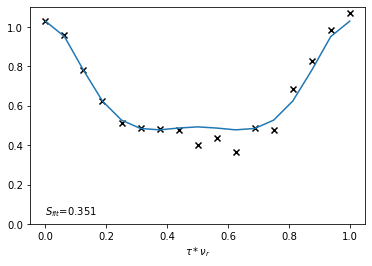

In [101]:
ds=DS(nH=2,sym=sym,vr=vr,N=N,LG=LG)
_=ds.plot(I=I)

## Compare curves for different numbers of spins

### 1 spin vs. 2 spins
We generate 2-spin curves and fit them to the 1-spin curves. We also plot the input S vs. the fitted S.

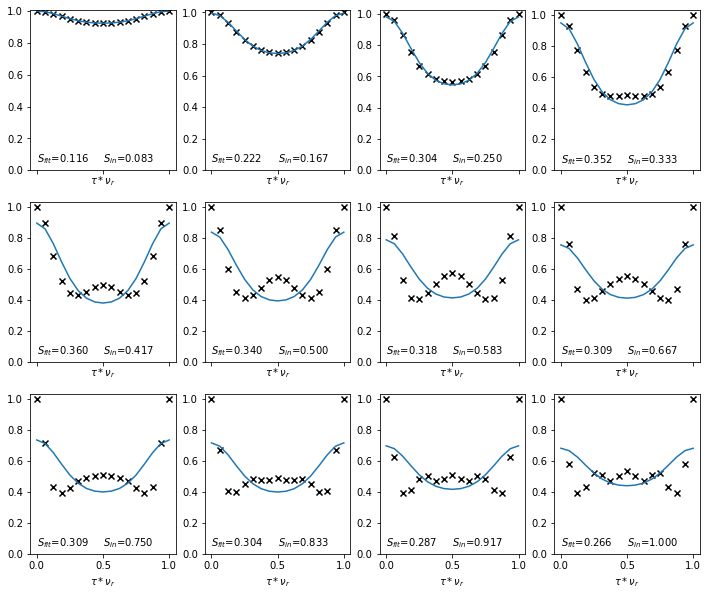

In [102]:
ds1=DS(1,True,vr,N)
ds2=DS(2,True,vr,N)

S0=np.linspace(0,1,13)[1:]
fig,ax=plt.subplots(3,4,sharex=True,figsize=[12,10])
ax=ax.flatten()

Sfit=[]

for S,a in zip(S0,ax):
    I=ds2.I(S=S)
    Sf,A=ds1.fit(I=I)
    Sfit.append(Sf)
    ds1.plot(I=I,S=Sf,A=A,ax=a)
    a.text(.5,.05,fr'$S_{{in}}$={S:.3f}')

#### Plot $S_{input}$ vs. $S_{fit}$

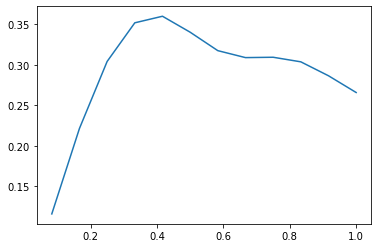

In [103]:
ax=plt.subplots()[1]
_=ax.plot(S0,Sfit)

### 1 spin vs. 3 spins
We generate 3-spin curves and fit them to the 1-spin curves. We also plot the input S vs. the fitted S.

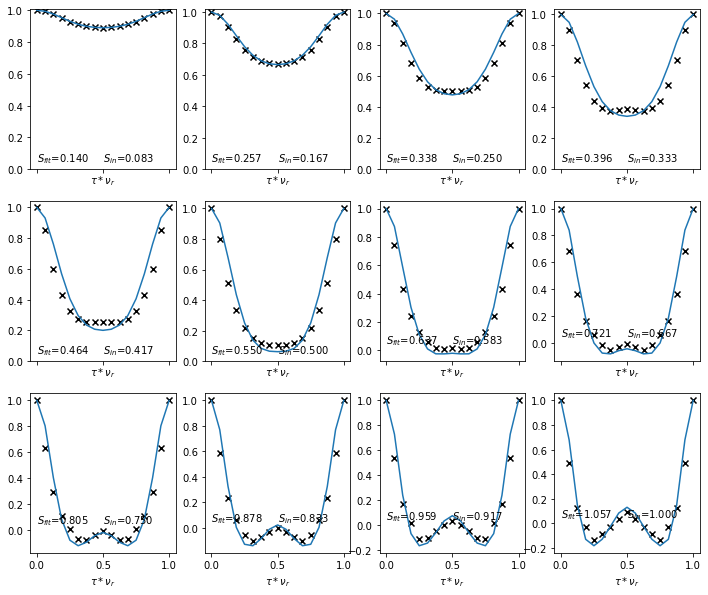

In [104]:
ds1=DS(1,True,vr,N)
ds3=DS(3,True,vr,N)

S0=np.linspace(0,1,13)[1:]
fig,ax=plt.subplots(3,4,sharex=True,figsize=[12,10])
ax=ax.flatten()

Sfit=[]

for S,a in zip(S0,ax):
    I=ds3.I(S=S)
    Sf,A=ds1.fit(I=I)
    Sfit.append(Sf)
    ds1.plot(I=I,S=Sfit[-1],ax=a)
    a.text(.5,.05,fr'$S_{{in}}$={S:.3f}')

#### Plot $S_{input}$ vs. $S_{fit}$

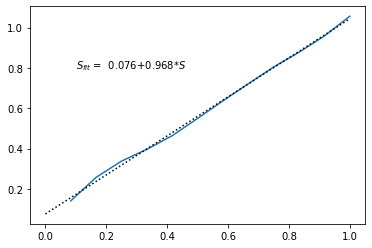

In [105]:
ax=plt.subplots()[1]
_=ax.plot(S0,Sfit)
a,b=np.polyfit(S0,Sfit,1)
ax.plot([0,1],[b,b+a],color='black',linestyle=':')
_=ax.text(.1,.8,fr'$S_{{fit}}$ =  {b:.3f}+{a:.3f}*$S$')

In [5]:
for nH in [1,2,3]:
    DS(nH=nH,sym=True,N=17,vr=5000,LG=True).generate_library(filename=
        f'/Users/albertsmith/Documents/DynamicsLaptop/GlpG/NMRCardiolipin/DS_sims/nH{nH}_N17_vr5000_symTrue.txt',nS=401,maxS=0.25)


Saved to:/Users/albertsmith/Documents/DynamicsLaptop/GlpG/NMRCardiolipin/DS_sims/nH1_N17_vr5000_symTrue.txt
Saved to:/Users/albertsmith/Documents/DynamicsLaptop/GlpG/NMRCardiolipin/DS_sims/nH2_N17_vr5000_symTrue.txt
Saved to:/Users/albertsmith/Documents/DynamicsLaptop/GlpG/NMRCardiolipin/DS_sims/nH3_N17_vr5000_symTrue.txt


In [2]:
for nH in [1,2,3]:
    DS(nH=nH,sym=True,N=17,vr=5000,LG=False).generate_library(filename=
        f'/Users/albertsmith/Documents/DynamicsLaptop/GlpG/NMRCardiolipin/DS_sims/nH{nH}_N17_vr5000_symTrue_noLG.txt',nS=401,maxS=0.25)


Saved to:/Users/albertsmith/Documents/DynamicsLaptop/GlpG/NMRCardiolipin/DS_sims/nH1_N17_vr5000_symTrue_noLG.txt
Saved to:/Users/albertsmith/Documents/DynamicsLaptop/GlpG/NMRCardiolipin/DS_sims/nH2_N17_vr5000_symTrue_noLG.txt
Saved to:/Users/albertsmith/Documents/DynamicsLaptop/GlpG/NMRCardiolipin/DS_sims/nH3_N17_vr5000_symTrue_noLG.txt


<AxesSubplot:xlabel='$\\tau*\\nu_r$'>

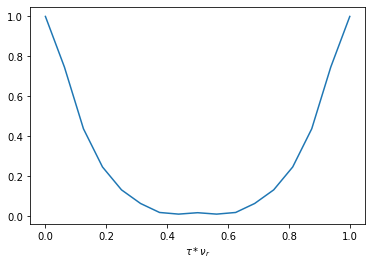

In [3]:
DS(3,sym=True,N=17,vr=5000,LG=True).plot(S=1)